# Lesson 6: Reward hacking

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code>  file:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

Start by importing dependencies and setting up two clients, one for OpenAI and one for Predibase:

In [1]:
import os
from datasets import load_dataset
from dotenv import load_dotenv
from openai import OpenAI

from utils import *

load_dotenv()

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

pb_client = OpenAI(
    base_url=os.environ["PREDIBASE_MODEL_LLAMA_URL"],
    api_key=os.environ["PREDIBASE_API_KEY"],
)

## Hacking the summarization task with longer summaries

Here, you'll see how longer summaries could lead to higher rewards. Start by loading the same earnings call dataset from the previous lesson:

In [2]:
ds = load_dataset("mrSoul7766/ECTSum")
transcript = ds["train"][1]["text"]

Generate a quiz based on the call:

In [3]:
quiz = generate_quiz(transcript)
print(quiz)


Question 1:
By what percent did comparable store sales grow in Q1?
A. 24.7%
B. 29.4%
C. 32.1%
D. 21.2%

Question 2:
What is the targeted number of new store openings for AAP in 2021?
A. 100 to 115
B. 150 to 200
C. 50 to 75
D. 75 to 100

Question 3:
What was the adjusted operating income for AAP in Q1?
A. $203 million
B. $299 million
C. $113 million
D. $330 million

Question 4:
What is the expected range for adjusted OI margin for the year?
A. 10% to 10.5%
B. 7% to 7.5%
C. 9% to 9.2%
D. 8% to 8.5%


Generate 8 summaries of the call (again, you'll use the Llama-3.1-8B-Instruct-dequantized, which is defined in the utils.py file):

In [4]:
prompt = f"""Generate a concise bulleted summary of the 
information in the following earnings call transcript.

Only respond with the summary, do not include any extraneous text.

Transcript:

{transcript}
"""

completions = pb_client.chat.completions.create(
    model=MODEL_NAME,
    messages=[
        {"role": "user", "content": prompt},
    ],
    n=8,
    temperature=0.9,
)

Use each summary to take the quiz and get a reward score:

In [5]:
responses = [choice.message.content for choice in completions.choices]
quiz_rewards = [quiz_reward(resp, quiz) for resp in responses]
quiz_rewards

[0.75, 1.0, 1.0, 0.75, 1.0, 0.75, 1.0, 1.0]

The transcript should get a perfect score: check that it does:

In [6]:
transcript_score = quiz_reward(transcript, quiz)
transcript_score

1.0

Check lengths of the 8 summaries and compare to full transcript:

In [7]:
lengths = [len(resp) for resp in responses]
lengths

[945, 915, 1284, 1335, 1318, 695, 1491, 1514]

In [8]:
len(transcript)

21810

## Create a penalty function to discourage longer summaries

Here, you'll create a reward function that assigns a negative score (i.e. a penalty) to the model for longer summaries. Over time during training, this penalty should discourage the model from getting higher quiz scores just by writing longer summaries.

In [9]:
def length_penalty_reward(response: str) -> float:
    length = len(response)
    target_length = 1024
    if length <= target_length:
        return 0.0
    else:
        return max(
            (target_length - length) / target_length,
            -10
        ) 

In [10]:
transcript_reward = length_penalty_reward(transcript)
transcript_reward

-10

Show the length penalties and resulting advantages for the 8 summaries:

In [11]:
lengths = [len(resp) for resp in responses]
length_rewards = [
    length_penalty_reward(resp) for resp in responses
]
print_length_table(lengths, length_rewards)

+---------+----------+-----------+-------------+
|   Index |   Length |    Reward |   Advantage |
+=========+==========+===========+=============+
|       0 |      945 |  0        |    1.18807  |
+---------+----------+-----------+-------------+
|       1 |      915 |  0        |    1.18807  |
+---------+----------+-----------+-------------+
|       2 |     1284 | -0.253906 |   -0.168233 |
+---------+----------+-----------+-------------+
|       3 |     1335 | -0.303711 |   -0.434276 |
+---------+----------+-----------+-------------+
|       4 |     1318 | -0.287109 |   -0.345595 |
+---------+----------+-----------+-------------+
|       5 |      695 |  0        |    1.18807  |
+---------+----------+-----------+-------------+
|       6 |     1491 | -0.456055 |   -1.24806  |
+---------+----------+-----------+-------------+
|       7 |     1514 | -0.478516 |   -1.36804  |
+---------+----------+-----------+-------------+


Add the length penalty to the quiz reward score:

In [12]:
def total_reward(length_reward, quiz_reward):
    return length_reward + quiz_reward

In [13]:
total_rewards = [
    total_reward(length_reward, quiz_reward) 
    for length_reward, quiz_reward
    in zip(length_rewards, quiz_rewards)
]

Visualize the trade-off between length and quiz score in determining advantages:

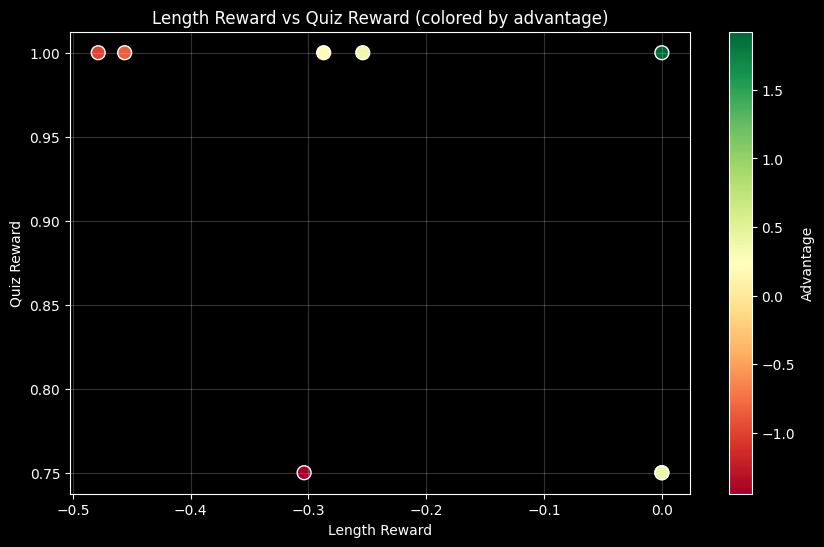

In [15]:
from matplotlib import pyplot as plt

advantages = compute_advantages(total_rewards)
min_adv = min(advantages)
max_adv = max(advantages)

plt.figure(figsize=(10,6), facecolor='black')
plt.style.use('dark_background')
scatter = plt.scatter(length_rewards, quiz_rewards, c=advantages, cmap='RdYlGn', s=100, edgecolor='white', vmin=min_adv, vmax=max_adv)
plt.colorbar(scatter, label='Advantage')
plt.xlabel('Length Reward')
plt.ylabel('Quiz Reward')
plt.title('Length Reward vs Quiz Reward (colored by advantage)')
plt.grid(True, alpha=0.2)
plt.show()